### Part 0. Import

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import itertools
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt


/tmp/ipykernel_1997524/3258298782.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error


In [5]:
from RAGE import RAGE
from XY_ORACLE import XY_ORACLE
from XY_STATIC import XY_STATIC
from RAGE_opt import RAGE_opt
from RAGE_center import RAGE_center

In [6]:
import logging

for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
    
logging.basicConfig(level=logging.CRITICAL, format='%(message)s')

logging.debug("This is a debug message and should not appear.")
logging.critical("This is a critical message and should appear.")


This is a critical message and should appear.


In [7]:
x_path = "/homes/gws/sqhang/proj/2024_sqhang_Transductive-bandits/data/tf_bind_8-x-0.npy"
x_arr = np.load(x_path, allow_pickle=True)
print(x_arr.shape)
print(x_arr[0, :])
y_path = "/homes/gws/sqhang/proj/2024_sqhang_Transductive-bandits/data/tf_bind_8-y-0.npy"
y_arr = np.load(y_path, allow_pickle=True)
print(y_arr.shape)
print(y_arr[0])

(65792, 8)
[0 0 0 0 0 0 0 0]
(65792, 1)
[0.5247495]


### Part 1. Train/test split

In [8]:
# We need to remove duplicates to prevent train-test leakage
df = pd.DataFrame(x_arr)

duplicates = df.duplicated(keep=False)

if duplicates.any():
    duplicate_rows = df[duplicates]
    corresponding_ys = y_arr[duplicates]

    grouped = duplicate_rows.groupby(list(df.columns)).indices
    for key, indices in grouped.items():
        print("Duplicate rows:", key, "Corresponding ys:", corresponding_ys[list(indices)])
else:
    print("No duplicates found.")


Duplicate rows: (0, 0, 0, 0, 3, 3, 3, 3) Corresponding ys: [[0.34148353]
 [0.34148353]]
Duplicate rows: (0, 0, 0, 1, 2, 3, 3, 3) Corresponding ys: [[0.53629446]
 [0.53629446]]
Duplicate rows: (0, 0, 0, 2, 1, 3, 3, 3) Corresponding ys: [[0.5280996]
 [0.5280996]]
Duplicate rows: (0, 0, 0, 3, 0, 3, 3, 3) Corresponding ys: [[0.59463775]
 [0.59463775]]
Duplicate rows: (0, 0, 1, 0, 3, 2, 3, 3) Corresponding ys: [[0.4407702]
 [0.4407702]]
Duplicate rows: (0, 0, 1, 1, 2, 2, 3, 3) Corresponding ys: [[0.6201707]
 [0.6201707]]
Duplicate rows: (0, 0, 1, 2, 1, 2, 3, 3) Corresponding ys: [[0.42126748]
 [0.42126748]]
Duplicate rows: (0, 0, 1, 3, 0, 2, 3, 3) Corresponding ys: [[0.36377975]
 [0.36377975]]
Duplicate rows: (0, 0, 2, 0, 3, 1, 3, 3) Corresponding ys: [[0.7867789]
 [0.7867789]]
Duplicate rows: (0, 0, 2, 1, 2, 1, 3, 3) Corresponding ys: [[0.41403127]
 [0.41403127]]
Duplicate rows: (0, 0, 2, 2, 1, 1, 3, 3) Corresponding ys: [[0.07736156]
 [0.07736156]]
Duplicate rows: (0, 0, 2, 3, 0, 1, 3, 3)

In [9]:
df = pd.DataFrame(x_arr)

unique_df = df.drop_duplicates(keep='first')

unique_indices = unique_df.index
y_arr = y_arr[unique_indices]

x_arr = unique_df.to_numpy()

print("Unique x_arr shape:", x_arr.shape)
print("Unique y_arr shape:", y_arr.shape)

Unique x_arr shape: (65536, 8)
Unique y_arr shape: (65536, 1)


In [10]:
x_train, x_test, y_train, y_test = train_test_split(x_arr, y_arr, test_size=0.5, random_state=42)

# Further split training set to create item set(full train set) and prob set
_, x_probe, _, y_probe = train_test_split(x_train, y_train, test_size=0.1, random_state=42)
print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)
print("Shape of x_probe:", x_probe.shape)
print("Shape of y_probe:", y_probe.shape)

Shape of x_train: (32768, 8)
Shape of x_test: (32768, 8)
Shape of y_train: (32768, 1)
Shape of y_test: (32768, 1)
Shape of x_probe: (3277, 8)
Shape of y_probe: (3277, 1)


### Part 2. Helper functions

In [11]:
def compute_correlations(y_true, y_pred):
    """
    Compute Pearson and Spearman correlations between the true and predicted values.
    
    Parameters:
    - y_true: array-like, true target values
    - y_pred: array-like, predicted target values
    
    Returns:
    - A dictionary containing Pearson and Spearman correlation coefficients
    """
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    pearson_corr, _ = pearsonr(y_true, y_pred)
    spearman_corr, _ = spearmanr(y_true, y_pred)
    
    return {'Pearson': pearson_corr, 'Spearman': spearman_corr}

### Part 3. Fit a naive linear model

In [12]:
model = LinearRegression()
model.fit(x_train, y_train)

y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

train_correlations = compute_correlations(y_train, y_train_pred)
print("Training Correlations:", train_correlations)

test_correlations = compute_correlations(y_test, y_test_pred)
print("Testing Correlations:", test_correlations)

Training Correlations: {'Pearson': 0.01577511226894357, 'Spearman': 0.014840048809623967}
Testing Correlations: {'Pearson': 0.000910791525390446, 'Spearman': -0.0018616243251931377}


Whoops! Barely no correlations. Let's try with a more meaningful featurization.

### Part 4. Kmer Linear Regression

In [13]:
def make_kmer_list(k, alphabet="ACGT", upto=False):
    """Generate sorted list of k-mers for each k up to the given k, considering reverse complements."""
    kmer_dict = {}
    if upto:
        range_k = range(1, k + 1)
    else:
        range_k = [k]
    for current_k in range_k:
        kmer_set = set()
        for kmer_tuple in itertools.product(alphabet, repeat=current_k):
            kmer = ''.join(kmer_tuple)
            rev_kmer = ''.join(reversed([{'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}[x] for x in kmer]))
            kmer_set.add(min(kmer, rev_kmer))
        kmer_dict[current_k] = sorted(kmer_set)
    # Flatten dictionary into a list while preserving order by k-mer length
    kmer_list = [kmer for sublist in range_k for kmer in kmer_dict[sublist]]
    return kmer_list, kmer_dict

In [14]:
### Counting k-mers
def count_kmers(sequences, k, normalize=None, upto=False):
    """Count k-mers in sequences for all lengths up to k if 'upto' is True, and optionally normalize the counts."""
    alphabet = {0: 'A', 1: 'C', 2: 'G', 3: 'T'}
    num_sequences = sequences.shape[0]
    kmer_list, kmer_dict = make_kmer_list(k, alphabet="ACGT", upto=upto)
    kmer_index = {kmer: idx for idx, kmer in enumerate(kmer_list)}
    kmer_matrix = np.zeros((num_sequences, len(kmer_list)), dtype=float)  # Changed dtype to float

    # Convert sequences to strings and count k-mers
    for i in range(num_sequences):
        sequence = ''.join(alphabet[b] for b in sequences[i])
        for current_k, kmers in kmer_dict.items():
            for j in range(len(sequence) - current_k + 1):
                kmer = sequence[j:j+current_k]
                rev_kmer = ''.join(reversed([{'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}[x] for x in kmer]))
                canonical_kmer = min(kmer, rev_kmer)
                if canonical_kmer in kmer_index:
                    kmer_matrix[i, kmer_index[canonical_kmer]] += 1

    if normalize:
        if normalize == "frequency":
            # Normalize separately for each k-length group
            for current_k, kmers in kmer_dict.items():
                indices = [kmer_index[kmer] for kmer in kmers]
                sums = kmer_matrix[:, indices].sum(axis=1, keepdims=True)
                kmer_matrix[:, indices] /= np.maximum(1, sums)
        elif normalize == "unitsphere":
            for current_k, kmers in kmer_dict.items():
                indices = [kmer_index[kmer] for kmer in kmers]
                norms = np.linalg.norm(kmer_matrix[:, indices], axis=1, keepdims=True)
                kmer_matrix[:, indices] /= np.maximum(1e-10, norms)

    return kmer_matrix

In [15]:
k = 2
x_train_kmer = count_kmers(x_train, k, normalize='frequency', upto=True)
print(x_train_kmer.shape)

(32768, 12)


In [16]:
k = 2
x_test_kmer = count_kmers(x_test, k, normalize='frequency', upto=True)
print(x_test_kmer.shape)

(32768, 12)


In [17]:
k = 2
x_probe_kmer = count_kmers(x_probe, k, normalize='frequency', upto=True)
print(x_probe_kmer.shape)

(3277, 12)


In [18]:
model_kmer = LinearRegression(fit_intercept=False)
model_kmer.fit(x_train_kmer, y_train)

y_train_pred_kmer = model_kmer.predict(x_train_kmer)
y_test_pred_kmer = model_kmer.predict(x_test_kmer)

kmer_train_correlations = compute_correlations(y_train, y_train_pred_kmer)
print("Training Correlations:", kmer_train_correlations)

kmer_test_correlations = compute_correlations(y_test, y_test_pred_kmer)
print("Testing Correlations:", kmer_test_correlations)

theta_star = model_kmer.coef_
intercept = model_kmer.intercept_
print(theta_star.T.shape)
print(intercept)

Training Correlations: {'Pearson': 0.7055797046027039, 'Spearman': 0.6656108051812356}
Testing Correlations: {'Pearson': 0.6983677103403714, 'Spearman': 0.6556447501872654}
(12, 1)
0.0


In [20]:
for k in [2, 3, 4, 5, 6, 7]:
    x_train_kmer = count_kmers(x_train, k, normalize='frequency', upto=True)
    x_test_kmer = count_kmers(x_test, k, normalize='frequency', upto=True)
    model_kmer = LinearRegression(fit_intercept=False)
    model_kmer.fit(x_train_kmer, y_train)

    y_train_pred_kmer = model_kmer.predict(x_train_kmer)
    y_test_pred_kmer = model_kmer.predict(x_test_kmer)

    kmer_train_correlations = compute_correlations(y_train, y_train_pred_kmer)
    print("Kmer", k, "Training Correlations:", kmer_train_correlations)

    kmer_test_correlations = compute_correlations(y_test, y_test_pred_kmer)
    print("Kmer", k, "Testing Correlations:", kmer_test_correlations)
    

Kmer 2 Training Correlations: {'Pearson': 0.7055797046027039, 'Spearman': 0.6656108051812356}
Kmer 2 Testing Correlations: {'Pearson': 0.6983677103403714, 'Spearman': 0.6556447501872654}
Kmer 3 Training Correlations: {'Pearson': 0.8036316496243272, 'Spearman': 0.748405083249481}
Kmer 3 Testing Correlations: {'Pearson': 0.7996589343091165, 'Spearman': 0.7419660891282936}
Kmer 4 Training Correlations: {'Pearson': 0.8464129424492275, 'Spearman': 0.789499117830905}
Kmer 4 Testing Correlations: {'Pearson': 0.8430080426393673, 'Spearman': 0.7833441126224462}
Kmer 5 Training Correlations: {'Pearson': 0.8675038206695029, 'Spearman': 0.8124548873690713}
Kmer 5 Testing Correlations: {'Pearson': 0.8619285353175897, 'Spearman': 0.802245526727893}
Kmer 6 Training Correlations: {'Pearson': 0.8924631014003094, 'Spearman': 0.8460441761135602}
Kmer 6 Testing Correlations: {'Pearson': 0.8732483916285695, 'Spearman': 0.8146897069587631}
Kmer 7 Training Correlations: {'Pearson': 0.9353430584618915, 'Spear

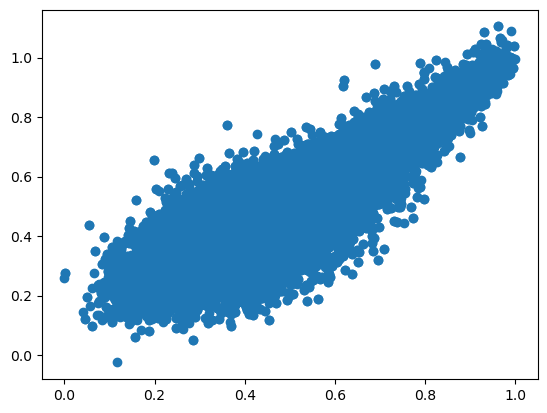

In [21]:
plt.scatter(y_test, y_test_pred_kmer)
plt.show()

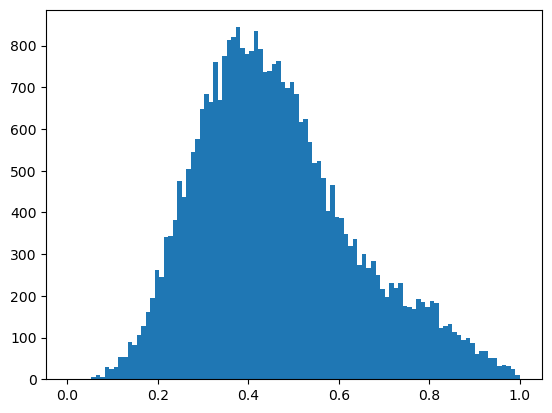

In [22]:
plt.hist(y_train, bins=100)
plt.show()

### Part 5. Kmer Kernel Methods

In [22]:
model_kmer_krr = KernelRidge(alpha=1.0, kernel='rbf', gamma=0.1)

model_kmer_krr.fit(x_train_kmer, y_train)

KernelRidge(alpha=1.0, gamma=0.1, kernel='rbf')

In [23]:
y_train_pred_kmer_krr = model_kmer_krr.predict(x_train_kmer)
y_test_pred_kmer_krr = model_kmer_krr.predict(x_test_kmer)

# Compute correlations or other performance metrics
kmer_train_correlations_krr = compute_correlations(y_train, y_train_pred_kmer_krr)
kmer_test_correlations_krr = compute_correlations(y_test, y_test_pred_kmer_krr)

print("Training Correlations (KRR):", kmer_train_correlations_krr)
print("Testing Correlations (KRR):", kmer_test_correlations_krr)

Training Correlations (KRR): {'Pearson': 0.8698403407591941, 'Spearman': 0.8153968202744548}
Testing Correlations (KRR): {'Pearson': 0.8712696485314264, 'Spearman': 0.8101305844413605}


In [ ]:
# Hyperparameter search code to run if have time
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': [0.1, 1, 10, 100],
              'gamma': np.logspace(-4, 1, 6)}

grid_search = GridSearchCV(KernelRidge(kernel='rbf'), param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(x_train_kmer, y_train)

best_krr_model = grid_search.best_estimator_

print("Best parameters:", grid_search.best_params_)

### Part 6. Kmer XGBoost Methods

In [25]:
import xgboost as xgb

In [40]:
x_train_kmer, x_val_kmer, y_train, y_val = train_test_split(
    x_train_kmer, y_train, test_size=0.2, random_state=42
)
print(x_train_kmer.shape)
print(x_val_kmer.shape)

(42106, 692)
(10527, 692)


In [41]:
dtrain = xgb.DMatrix(x_train_kmer, label=y_train)
dval = xgb.DMatrix(x_val_kmer, label=y_val)
dtest = xgb.DMatrix(x_test_kmer, label=y_test)

In [42]:
params = {
    'max_depth': 10,
    'eta': 0.1,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

In [43]:
num_boost_round = 5000
evals = [(dtrain, 'train'), (dval, 'validation')]
bst = xgb.train(params, dtrain, num_boost_round, evals=evals, early_stopping_rounds=10)

[0]	train-rmse:0.16184	validation-rmse:0.16177
[1]	train-rmse:0.15118	validation-rmse:0.15143
[2]	train-rmse:0.14179	validation-rmse:0.14244
[3]	train-rmse:0.13367	validation-rmse:0.13466
[4]	train-rmse:0.12653	validation-rmse:0.12788
[5]	train-rmse:0.12028	validation-rmse:0.12198
[6]	train-rmse:0.11491	validation-rmse:0.11693
[7]	train-rmse:0.11019	validation-rmse:0.11261
[8]	train-rmse:0.10611	validation-rmse:0.10887
[9]	train-rmse:0.10249	validation-rmse:0.10558
[10]	train-rmse:0.09937	validation-rmse:0.10280
[11]	train-rmse:0.09667	validation-rmse:0.10035
[12]	train-rmse:0.09426	validation-rmse:0.09832
[13]	train-rmse:0.09221	validation-rmse:0.09656
[14]	train-rmse:0.09031	validation-rmse:0.09498
[15]	train-rmse:0.08871	validation-rmse:0.09368
[16]	train-rmse:0.08725	validation-rmse:0.09246
[17]	train-rmse:0.08602	validation-rmse:0.09144
[18]	train-rmse:0.08482	validation-rmse:0.09054
[19]	train-rmse:0.08381	validation-rmse:0.08973
[20]	train-rmse:0.08279	validation-rmse:0.08898
[2

In [44]:
y_train_pred_xgb = bst.predict(dtrain)
y_test_pred_xgb = bst.predict(dtest)

# Assuming compute_correlations is defined to compute your metric of interest
xgb_train_correlations = compute_correlations(y_train, y_train_pred_xgb)
xgb_test_correlations = compute_correlations(y_test, y_test_pred_xgb)

print("Training Correlations (XGBoost):", xgb_train_correlations)
print("Testing Correlations (XGBoost):", xgb_test_correlations)

Training Correlations (XGBoost): {'Pearson': 0.9937048679572801, 'Spearman': 0.9918885296387072}
Testing Correlations (XGBoost): {'Pearson': 0.9413444233301491, 'Spearman': 0.9140121527133677}


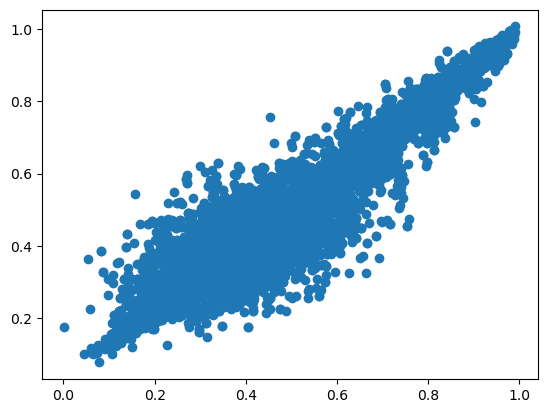

In [47]:
plt.scatter(y_test, y_test_pred_xgb)
plt.show()

### Part 7. Run Experiments on TF-bind8 Dataset

In [23]:
def precision_at_k(x_test_kmer, theta_hat, y_test, k):
    pred_y_reward = x_test_kmer @ theta_hat
    pred_y_reward = np.array(pred_y_reward)
    y_test = np.array(y_test)
    
    # Flatten arrays just in case they are not in flat shape
    pred_y_reward = pred_y_reward.flatten()
    y_test = y_test.flatten()

    # Get indices of the sorted predictions (in descending order)
    pred_indices = np.argsort(pred_y_reward)[::-1]

    # Select top p indices from sorted predictions
    top_p_pred_indices = pred_indices[:k]

    # Now find the top p actual values
    actual_indices = np.argsort(y_test)[::-1]
    top_p_actual_indices = set(actual_indices[:k])

    # Check how many of the top p predictions are in the top p actual
    hit_count = sum(idx in top_p_actual_indices for idx in top_p_pred_indices)

    precision = hit_count / k
    return precision * 100


In [26]:
delta = 0.05
kmer_k_list = [2, 3, 4]
factor = 5
seeds = [42, 123, 789]
precision_k_list = [10, 50, 100, 200, 500, 1000]

rage_opt_dict = {}
rage_center_dict = {}

for k in kmer_k_list:
    x_train_kmer = count_kmers(x_train, k, normalize='frequency', upto=True)
    x_test_kmer = count_kmers(x_test, k, normalize='frequency', upto=True)
    x_probe_kmer = count_kmers(x_probe, k, normalize='frequency', upto=True)
    
    model_kmer = LinearRegression(fit_intercept=False)
    model_kmer.fit(x_train_kmer, y_train)

    theta_star = model_kmer.coef_
    
    rage_opt_dict[k] = {}
    rage_center_dict[k] = {}
    
    for seed in seeds:
        print(k, seed)
        
        rage_opt_dict[k][seed] = {}
        rage_center_dict[k][seed] = {}
        
        rage_opt_instance = RAGE_opt(x_probe_kmer, theta_star.T, factor, delta, x_train_kmer)
        rage_opt_instance.algorithm(seed, var=False, sigma=0.1, stop_arm_count=2, rel_thresh=0.05)
        if not rage_opt_instance.success:
            print(f"Warning: rage_opt not succeed for kmer={k}, seed={seed}\n")
        
        rage_opt_dict[k][seed]["num_active"] = [int(item[2]) for item in rage_opt_instance.theta_hat_list]
        rage_opt_dict[k][seed]["theta_hat"] = [list(item[1].flatten()) for item in rage_opt_instance.theta_hat_list]
        for k2 in precision_k_list:
            rage_opt_dict[k][seed][k2] = {}
            train_rage_opt_precision_list = [(int(item[0]), precision_at_k(x_train_kmer, item[1], y_train, k=k2)) for item in rage_opt_instance.theta_hat_list]
            rage_opt_dict[k][seed][k2]["train"] = train_rage_opt_precision_list            
            test_rage_opt_precision_list = [(int(item[0]), precision_at_k(x_test_kmer, item[1], y_test, k=k2)) for item in rage_opt_instance.theta_hat_list]
            rage_opt_dict[k][seed][k2]["test"] = test_rage_opt_precision_list
        
        rage_center_instance = RAGE_center(x_probe_kmer, theta_star.T, factor, delta, x_train_kmer)
        rage_center_instance.algorithm(seed, var=False, sigma=0.1, stop_arm_count=2, rel_thresh=0.05)
        if not rage_center_instance.success:
            print(f"Warning: rage_center not succeed for kmer={k}, seed={seed}\n")
        
        rage_center_dict[k][seed]["num_active"] = [int(item[2]) for item in rage_center_instance.theta_hat_list]
        rage_center_dict[k][seed]["theta_hat"] = [list(item[1].flatten()) for item in rage_center_instance.theta_hat_list]
        for k2 in precision_k_list:
            rage_center_dict[k][seed][k2] = {}
            train_rage_center_precision_list = [(int(item[0]), precision_at_k(x_train_kmer, item[1], y_train, k=k2)) for item in rage_center_instance.theta_hat_list]
            rage_center_dict[k][seed][k2]["train"] = train_rage_center_precision_list            
            test_rage_center_precision_list = [(int(item[0]), precision_at_k(x_test_kmer, item[1], y_test, k=k2)) for item in rage_center_instance.theta_hat_list]
            rage_center_dict[k][seed][k2]["test"] = test_rage_center_precision_list


2 42


Succeeded? True
Sample complexity 1616
Succeeded? True
Sample complexity 1462


2 123


Succeeded? True
Sample complexity 1853
Succeeded? True
Sample complexity 1162


2 789


Succeeded? True
Sample complexity 1885
Succeeded? True
Sample complexity 1462


3 42


Succeeded? True
Sample complexity 21838
Succeeded? True
Sample complexity 4427


3 123


Succeeded? True
Sample complexity 21426
Succeeded? True
Sample complexity 4887


3 789


Succeeded? True
Sample complexity 20447
Succeeded? True
Sample complexity 4427


4 42


Succeeded? True
Sample complexity 99077
Succeeded? True
Sample complexity 45010


4 123


Succeeded? True
Sample complexity 104014
Succeeded? True
Sample complexity 44292


4 789


Succeeded? True
Sample complexity 97808
Succeeded? True
Sample complexity 44441


In [46]:
def plot_densify(arrays, labels, y_title="Precision at top500", y_lim = (10, 50)):
    # Define colors
    colors = plt.get_cmap('magma')
    num_lines = len(arrays)
    color_indices = np.linspace(0.0, 0.9, num_lines)

    plt.figure(figsize=(6, 5))

    # Interpolate and plot each sublist in the input arrays
    for idx, (sublists, label) in enumerate(zip(arrays, labels)):
        new_xs = []
        new_ys = []

        # Process each sublist
        for sublist in sublists:
            arr = np.array(sublist)
            min_x, max_x = min(arr[:,0]), max(arr[:,0])
            new_x = np.linspace(min_x, max_x, 100)
            new_y = np.interp(new_x, arr[:,0], arr[:,1])

            new_xs.append(new_x)
            new_ys.append(new_y)

        # Calculate the mean of new_x and new_y across all sublists
        midx = np.mean(new_xs, axis=0)
        midy = np.mean(new_ys, axis=0)

        # Plot densified curves
        color = colors(color_indices[idx])
        plt.plot(midx, midy, label=label, color=color, linestyle="dashdot")

    plt.xlabel('Sample Complexity')
    plt.ylabel(y_title)
    plt.xscale("log")
    plt.ylim((y_lim[0], y_lim[1]))
    plt.legend(frameon=False, fontsize="small")
    plt.show()


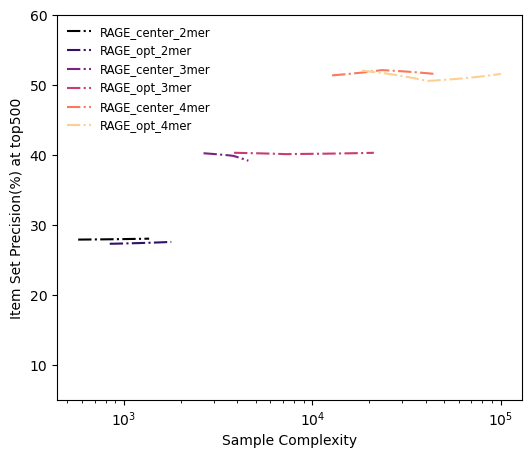

In [65]:
densify_data_list_train = []
label_list_train = []
seeds = [42, 123, 789]
for kmer in [2, 3, 4]:
    center_list = [np.array(rage_center_dict[kmer][seed][500]['train']) for seed in seeds]
    center_label = f"RAGE_center_{kmer}mer"
    opt_list = [np.array(rage_opt_dict[kmer][seed][500]['train']) for seed in seeds]
    opt_label = f"RAGE_opt_{kmer}mer"
    densify_data_list_train.append(center_list)
    densify_data_list_train.append(opt_list)
    label_list_train.append(center_label)
    label_list_train.append(opt_label)
    
plot_densify(densify_data_list_train, label_list_train, y_lim=(5, 60), y_title = "Item Set Precision(%) at top500")

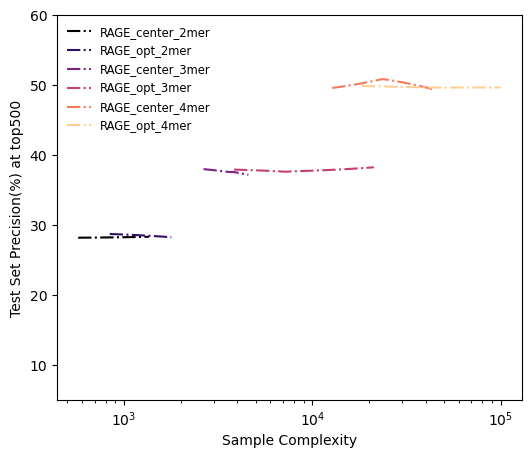

In [64]:
densify_data_list_test = []
label_list_test = []
seeds = [42, 123, 789]
for kmer in [2, 3, 4]:
    center_list = [np.array(rage_center_dict[kmer][seed][500]['test']) for seed in seeds]
    center_label = f"RAGE_center_{kmer}mer"
    opt_list = [np.array(rage_opt_dict[kmer][seed][500]['test']) for seed in seeds]
    opt_label = f"RAGE_opt_{kmer}mer"
    densify_data_list_test.append(center_list)
    densify_data_list_test.append(opt_list)
    label_list_test.append(center_label)
    label_list_test.append(opt_label)
    
plot_densify(densify_data_list_test, label_list_test, y_lim=(5, 60), y_title = "Test Set Precision(%) at top500")

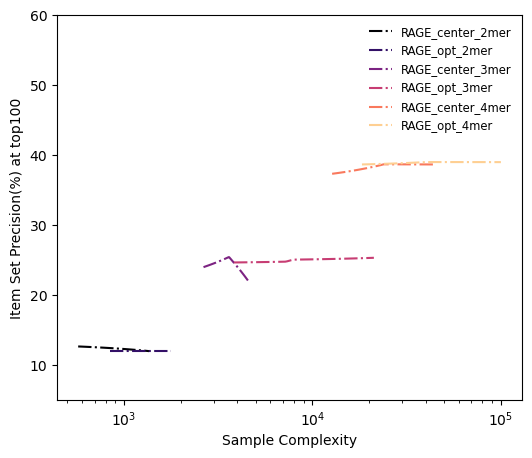

In [68]:
densify_data_list_test = []
label_list_test = []
seeds = [42, 123, 789]
for kmer in [2, 3, 4]:
    center_list = [np.array(rage_center_dict[kmer][seed][100]['train']) for seed in seeds]
    center_label = f"RAGE_center_{kmer}mer"
    opt_list = [np.array(rage_opt_dict[kmer][seed][100]['train']) for seed in seeds]
    opt_label = f"RAGE_opt_{kmer}mer"
    densify_data_list_test.append(center_list)
    densify_data_list_test.append(opt_list)
    label_list_test.append(center_label)
    label_list_test.append(opt_label)
    
plot_densify(densify_data_list_test, label_list_test, y_lim=(5, 60), y_title = "Item Set Precision(%) at top100")

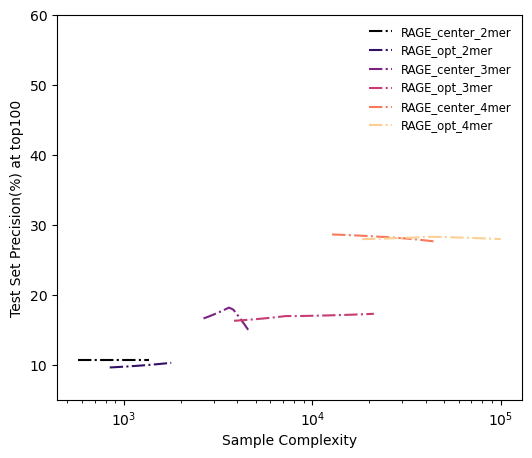

In [67]:
densify_data_list_test = []
label_list_test = []
seeds = [42, 123, 789]
for kmer in [2, 3, 4]:
    center_list = [np.array(rage_center_dict[kmer][seed][100]['test']) for seed in seeds]
    center_label = f"RAGE_center_{kmer}mer"
    opt_list = [np.array(rage_opt_dict[kmer][seed][100]['test']) for seed in seeds]
    opt_label = f"RAGE_opt_{kmer}mer"
    densify_data_list_test.append(center_list)
    densify_data_list_test.append(opt_list)
    label_list_test.append(center_label)
    label_list_test.append(opt_label)
    
plot_densify(densify_data_list_test, label_list_test, y_lim=(5, 60), y_title = "Test Set Precision(%) at top100")

In [164]:
import json

def save_dict(json_filepath, dict_to_save):
    with open(json_filepath, 'w') as f:
        json.dump(dict_to_save, f)

def load_json(json_filepath):
    with open(json_filepath, 'r') as f:
        return json.load(f)

In [165]:
import os

outdir = "/homes/gws/sqhang/proj/2024_sqhang_Transductive-bandits/outputs/real_dataset"

save_dict(os.path.join(outdir, "rage_opt.json"), rage_opt_dict)
save_dict(os.path.join(outdir, "rage_center.json"), rage_center_dict)

In [ ]:
load_json("/homes/gws/sqhang/proj/2024_sqhang_Transductive-bandits/outputs/real_dataset/rage_center.json")